In [3]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [4]:
name = 'mopv1_exc_2datasets_datav8_190814'
outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
output_imputed_data_format = outdir + '/imputed_data_{}_{{}}.npy'.format(name)
output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
output_cluster_centroids = outdir + '/centroids_{}.pkl'.format(name)


In [5]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/organized_mop_v1_exc'

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [6]:
mods_selected = [
#     'snmcseq_gene',
#     'snatac_gene',
    'smarter_cells',
#     'smarter_nuclei',
#     '10x_cells', 
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_Macosko',
    'smarter-cells-v1'
    ]

features_selected = ['smarter_cells', 'smarter-cells-v1']
# check features
for features_modality in features_selected:
    assert (features_modality in mods_selected)

# within modality
ps = {'mc': 0.9,
      'atac': 0.1,
      'rna': 0.7,
     }
drop_npcs = {'mc': 0,
      'atac': 0,
      'rna': 0,
     }

# across modality
cross_mod_distance_measure = 'correlation' # cca
knn = 10 
relaxation = 10 
n_cca = 30

# PCA
npc = 50

# clustering
k = 30
resolutions = [0.1, 1, 2, 4]
# umap
umap_neighbors = 30
min_dist=min_dist = 0.5

## Read in data 

In [7]:
log = snmcseq_utils.create_logger()
logging.info('*')

08/15/2019 01:03:38 PM *


In [8]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

smarter_cells (4152, 11)
smarter-cells-v1 (7366, 50)


In [9]:
gxc_hvftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        f_mat = hvftrs_f.format(mod, 'tsv')
        gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
        gxc_hvftrs[mod].index = SCF_utils.standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
        print(gxc_hvftrs[mod].shape, time.time()-ti)
        assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
        continue
        
        
    f_mat = hvftrs_f.format(mod, 'npz')
    f_gene = hvftrs_gene.format(mod)
    f_cell = hvftrs_cell.format(mod)
    _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
    _gene = _gxc_tmp.gene
    _cell = _gxc_tmp.cell
    _mat = _gxc_tmp.data

    _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
    ## remove duplicated genes (for now)
    u, c = np.unique(_gene, return_counts=True)
    dup = u[c > 1]
    uniq_bool = np.array([False if gene in dup else True for gene in _gene])
    _gene_selected = _gene[uniq_bool]
    _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
    _gene = _gene_selected
    _mat = _mat.tocsr()[_gene_selected_idx, :]
    ## remove duplicated genes complete
    
    gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
    assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
    print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

smarter_cells
(4176, 4152) 1.0267460346221924
smarter-cells-v1
(7686, 7366) 1.9632365703582764


## All done, making plots after 

- Plotting packages

In [10]:
f = output_clst_and_umap

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]

print(df_info.shape)
df_info.head()

(11518, 10)


,cluster_joint_r0.1,cluster_joint_r1,cluster_joint_r2,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot
sample,,,,,,,,,,
LS-15395_S43_E1-50,7,9,17,30,-7.013664,10.134144,smarter_cells,SMART cells,46,L6 NP Trh
LS-15395_S44_E1-50,7,9,19,19,-9.375187,11.082741,smarter_cells,SMART cells,45,L5 NP Slc17a8
LS-15395_S46_E1-50,1,4,3,5,5.077952,7.952013,smarter_cells,SMART cells,38,L5 IT S100b_2
LS-15395_S48_E1-50,1,4,3,22,4.788595,10.278378,smarter_cells,SMART cells,38,L5 IT S100b_2
LS-15395_S50_E1-50,4,7,5,11,10.161666,4.266432,smarter_cells,SMART cells,38,L5 IT S100b_2


In [11]:
# clean up annotation
df_info['annot'] = df_info['annot'].str.replace('_Glutamatergic', '')
df_info['annot'] = df_info['annot'].str.replace('_GABAergic', '')
df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

In [12]:
# gene by cell matrix 

mods_ordered = mods_selected
n_gene_cum = []
n_cell_cum = []
n_genes = []
n_cells = []

n_gene_curr = 0
n_cell_curr = 0

mod_genes = {}
for mod in mods_ordered:
    if settings[mod].mod_category == 'mc':
        n_gene, n_cell = gxc_hvftrs[mod].shape
        mod_genes[mod] = gxc_hvftrs[mod].index.values 
    else:
        n_gene, n_cell = gxc_hvftrs[mod].data.shape
        mod_genes[mod] = gxc_hvftrs[mod].gene 
        
    n_gene_curr += n_gene
    n_cell_curr += n_cell
    n_gene_cum.append(n_gene_curr)
    n_cell_cum.append(n_cell_curr)
    n_genes.append(n_gene) 
    n_cells.append(n_cell) 
    
mod_names = {mod: settings[mod].name for mod in mods_ordered}

In [13]:
def plot_0():
    import matplotlib.patches as patches
    with sns.axes_style('ticks'):
        fig = plt.figure(figsize=(6,8))
        ax = fig.add_axes([0, 0, 0.7, 1]) 

        for n_gene in n_gene_cum:
            ax.axvline(n_gene, color='gray', linewidth=1)
        for n_cell in n_cell_cum:
            ax.axhline(n_cell, color='gray', linewidth=1)
        for i in range(len(mods_ordered)):
            if i == 0:
                left_x = 0
                left_y = 0
                length_x = n_gene_cum[i]
                length_y = n_cell_cum[i]
            else:
                left_x = n_gene_cum[i-1]
                left_y = n_cell_cum[i-1]
                length_x = n_gene_cum[i] - n_gene_cum[i-1]
                length_y = n_cell_cum[i] - n_cell_cum[i-1]

            # Add the patch to the Axes
            rect = patches.Rectangle((left_x, left_y), length_x, length_y, 
                                     linewidth=1, 
                                     edgecolor=None,
                                     facecolor=settings[mods_ordered[i]].color)
            ax.add_patch(rect)
            # Add y ticks
            ax.text(-500, 
                    left_y + 1.0/2*length_y,
                    n_cells[i],
                    ha='left',
                    va='center',
                   )
            # Add x ticks
            ax.text(left_x + 1.0/2*length_x,
                    n_cell_cum[-1] + 5000,
                    n_genes[i], rotation=90,
                    ha='center',
                    va='bottom',
                   )
        ax.set_facecolor('lightgray')

        ax.set_xlim([n_gene_cum[-1], 0]) # flip axies
        ax.set_xticks(n_gene_cum[:-1])
        ax.set_xticklabels([])
        ax.set_xlabel('Highly variable genes')

        ax.set_ylim([0, n_cell_cum[-1]])
        ax.set_yticks(n_cell_cum[:-1])
        ax.set_yticklabels([])
        ax.set_ylabel('Cells')
        ax.tick_params(top=True, right=True)

        # colorbar 
        cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6]) 
        ax = cbar_ax
        for i in range(len(mods_ordered)):

            # Add the patch to the Axes
            left_x, left_y = 0, i
            length_x, length_y = 1, 1
            rect = patches.Rectangle((left_x, left_y), length_x, length_y, 
                                     linewidth=1, 
                                     edgecolor=None,
                                     facecolor=settings[mods_ordered[i]].color)
            ax.add_patch(rect)

            # add labels
            ax.text(1.5, 
                    left_y + 1.0/2*length_y,
                    settings[mods_ordered[i]].name,
                    ha='left',
                    va='center',
                   )
        ax.set_xticks([]) 
        ax.set_yticks([]) 
        ax.set_xlim([0, 1])
        ax.set_ylim([0, len(mods_ordered)])

        fig.savefig(output_figures.format('001', 'pdf'), bbox_inches='tight')
        plt.show()

        
def plot_S0():
    n_genes_impute = pd.DataFrame(index=mods_ordered, columns=mods_ordered)
    for mod_x, mod_y in itertools.combinations(mods_ordered, 2):
        n = len(np.intersect1d(mod_genes[mod_x], mod_genes[mod_y]))
    #     n_genes_impute.loc[mod_x, mod_y] = n
        n_genes_impute.loc[mod_y, mod_x] = n

    fig, ax = plt.subplots(figsize=(6,4))
    sns.heatmap(n_genes_impute.fillna(np.nan).rename(index=mod_names, columns=mod_names),
                ax=ax, cmap='rocket_r', cbar_kws={'label': 'Intersection of\nhighly variable genes'})
    fig.savefig(output_figures.format('002', 'pdf'), bbox_inches='tight')
    plt.show()
    
def plot_1():
    from matplotlib.gridspec import GridSpec

    sample_n = min(len(df_info), 20000)
    n_resolutions = len(resolutions)
    with sns.plotting_context('talk'):
        fig = plt.figure(figsize=(8*2,6*2))
        gs = GridSpec(2, n_resolutions)

        ax = fig.add_subplot(gs[0, :])
        kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_kws=legend_kws,
                                          kw_colors=kw_colors,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')

        layouts = [(1, i) for i in range(n_resolutions)]
        for resolution, layout in zip(resolutions, layouts):
            ax = fig.add_subplot(gs[layout[0], layout[1]])
            tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
            snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                              legend_mode=-1,
                                              sample_n=sample_n,
                                              rasterized=True,
                                              s=2,
                                             )
            ax.set_aspect('equal')
            ax.axis('off')
            ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

        fig.tight_layout()
        fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
        plt.show()

In [131]:
# plot_0()
# plot_S0()

def plot_1_mod(output=output_figures.format('1-mod', 'pdf')):
    """
    """
    sample_n = min(len(df_info), 20000)
    with sns.plotting_context('talk'):
        fig, ax = plt.subplots(figsize=(8,6))

        kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_kws=legend_kws,
                                          kw_colors=kw_colors,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')

        fig.tight_layout()
        fig.savefig(output, bbox_inches='tight', dpi=300)
        plt.show()

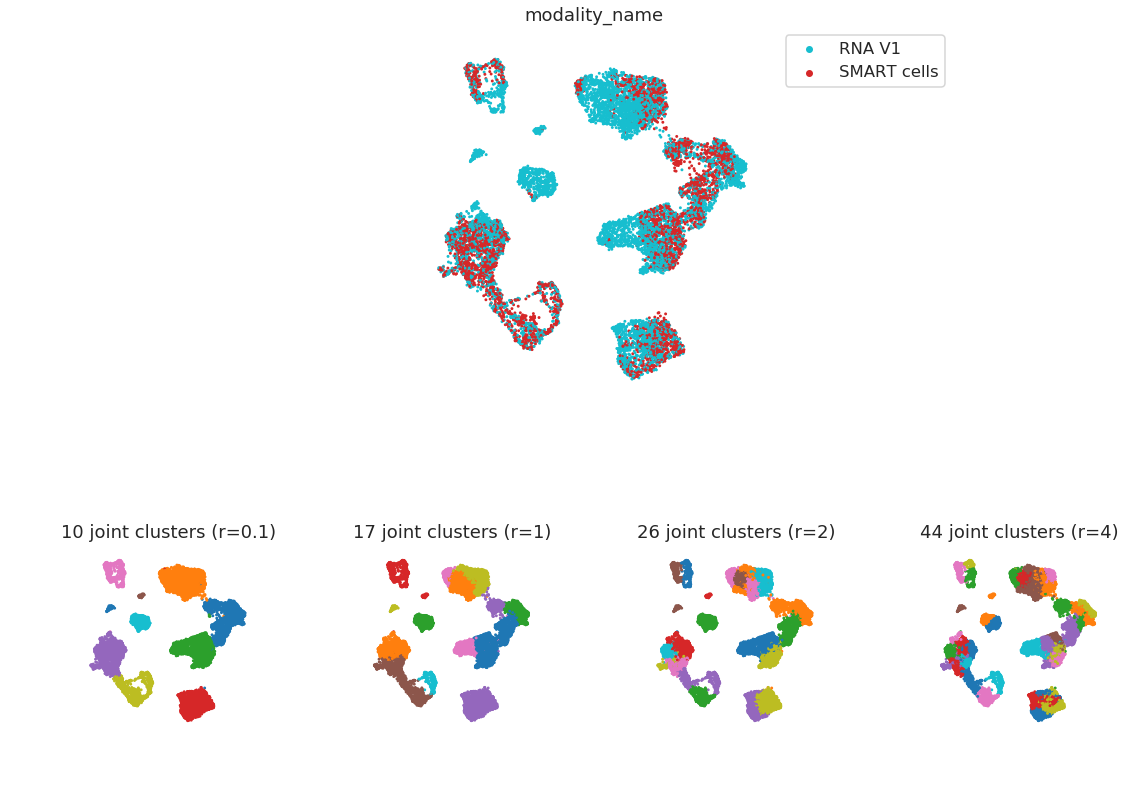

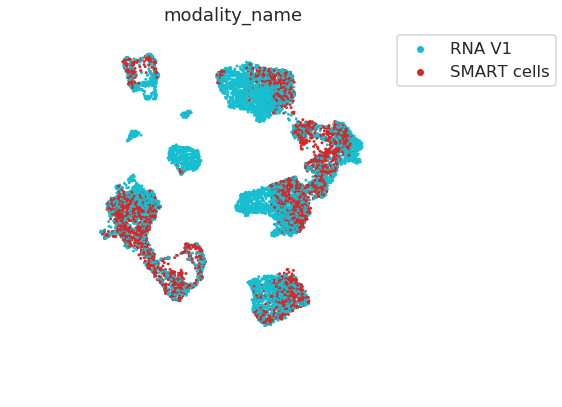

In [132]:
plot_1()
plot_1_mod()

In [16]:
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())


for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1']]
             .groupby(['cluster_joint_r1']).median())
joint_annot = df_info.groupby(['cluster_joint_r1']).agg({'annot': lambda x: x.value_counts().index.values[0]})
joint_annot.head()

,annot
cluster_joint_r1,
1,L4 IT VISp Rspo1
2,L2/3 IT VISp Agmat
3,L6 CT Grp_1
4,L6 IT VISp Penk Col27a1
5,L6 IT VISp Penk Col27a1


In [17]:
df_info.head()

,cluster_joint_r0.1,cluster_joint_r1,cluster_joint_r2,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot
sample,,,,,,,,,,
LS-15395_S43_E1-50,7,9,17,30,-7.013664,10.134144,smarter_cells,SMART cells,46,L6 NP Trh
LS-15395_S44_E1-50,7,9,19,19,-9.375187,11.082741,smarter_cells,SMART cells,45,L5 NP Slc17a8
LS-15395_S46_E1-50,1,4,3,5,5.077952,7.952013,smarter_cells,SMART cells,38,L5 IT S100b_2
LS-15395_S48_E1-50,1,4,3,22,4.788595,10.278378,smarter_cells,SMART cells,38,L5 IT S100b_2
LS-15395_S50_E1-50,4,7,5,11,10.161666,4.266432,smarter_cells,SMART cells,38,L5 IT S100b_2


In [18]:

def plot_1_single(kw_colors='', show_labels=False, output=''):
    with sns.plotting_context('talk'):
        fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r1'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
    #                                       legend_kws=legend_kws,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
                                          kw_colors=kw_colors,
                                          legend_mode=-1,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        if show_labels:
            for clst, centroid in centroids['joint'].iterrows():
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        str(clst)+'_'+joint_annot.loc[clst, 'annot'],
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=10,
                       )

        fig.savefig(output, bbox_inches='tight', dpi=300)
        plt.show()
        
def plot_2_single(label=False):
    with sns.plotting_context('talk'):
        fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
        kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
        legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_kws=legend_kws,
                                          sample_n=sample_n,
                                          legend_size=30,
                                          rasterized=True,
                                          kw_colors=kw_colors,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')

        fig.savefig(output_figures.format('2-nolabel', 'pdf'), bbox_inches='tight', dpi=300)
        plt.show()

def plot_3(show_labels=False):
    with sns.plotting_context('talk'):
        n = len(mods_selected)
        nx = 3
        ny = int((n+nx-1)/nx)
        fig, axs = plt.subplots(ny, nx, figsize=(6*nx,6*ny))
        axs = axs.flatten()
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'
    #     tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'annot'

        for ax, mod in zip(axs, mods_selected):
            snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
    #                                           legend_kws=legend_kws,
                                              sample_n=sample_n,
                                              legend_mode=-1,
                                              rasterized=True,
                                              s=2,
                                             )
            ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
        
            if show_labels:
                for clst, centroid in centroids[mod].iterrows():
                    facecolor='white'
                    ax.text(centroid.values[0], 
                            centroid.values[1], 
                            clst,
                            color='black', 
                            bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                            fontsize=10,
                           )
            ax.set_aspect('equal')
            ax.axis('off')
        for ax in axs[n:]:
            ax.axis('off')


        fig.subplots_adjust(wspace=0.05, hspace=0.05)
        fig.savefig(output_figures.format('3-nolabel', 'pdf'), bbox_inches='tight', dpi=300)
        plt.show()


In [19]:
# joint_clsts_colors = 
clsts = np.sort(df_info['cluster_joint_r1'].unique())
colors = snmcseq_utils.gen_colors(len(clsts))
joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}
# joint_clst_colors

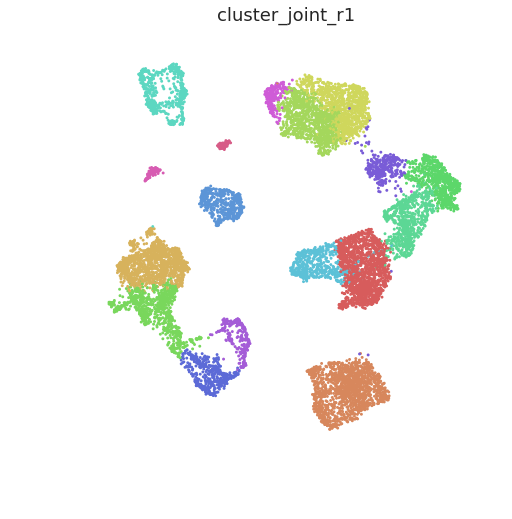

In [20]:
sample_n = 20000
plot_1_single(joint_clst_colors, show_labels=False, output=output_figures.format('1-nolabel', 'pdf'))
# plot_2_single()

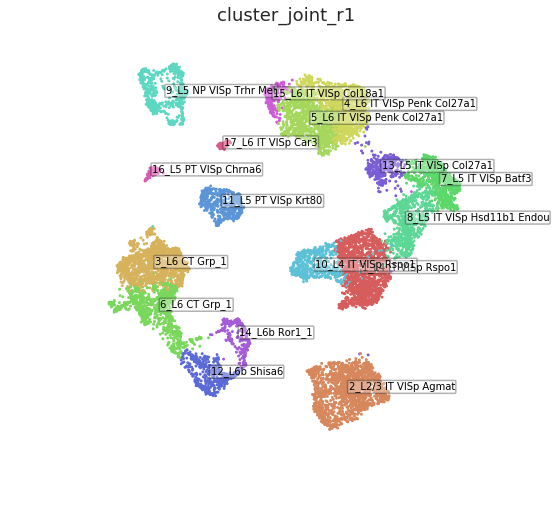

In [21]:
plot_1_single(joint_clst_colors, show_labels=True, output=output_figures.format('1-label', 'pdf'))

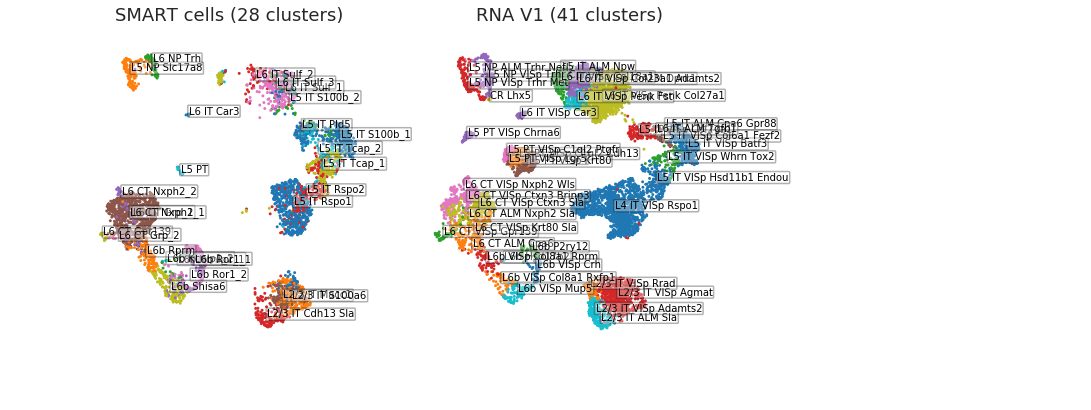

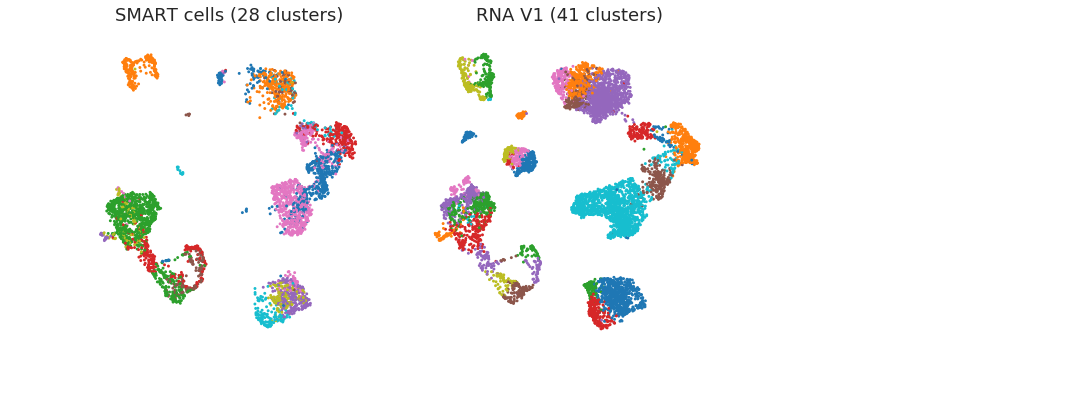

In [22]:
plot_3(show_labels=True)
plot_3(show_labels=False)

In [23]:
# Confusion matrix
# histograms
hist = df_info.groupby(['cluster_joint_r1', 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)
hist_enrich.head()

modality,smarter-cells-v1,smarter_cells
cluster_joint_r1,,
1,0.910800,1.158125
2,1.013783,0.975567
3,0.870089,1.230256
4,0.934396,1.116253
5,1.532740,0.055974


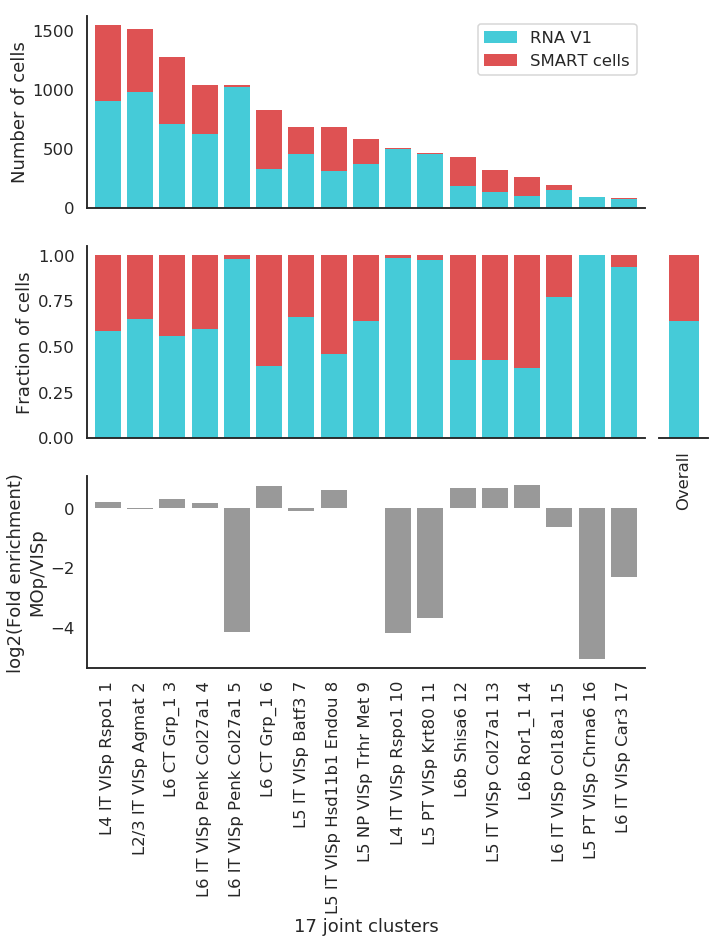

In [24]:
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})

with sns.plotting_context('talk'), sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    # histograms
    fig, axs = plt.subplots(3, 1, figsize=(10,4*3))
    ax = axs[0]
    hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    sns.despine(ax=ax)
    ax.set_ylabel('Fraction of cells')
    ax.set_xticklabels([])
    ax.set_xlabel('')
    
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    sns.despine(ax=ax, left=True)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
    ax = axs[2]
    (np.log2(hist_enrich['smarter_cells']).to_frame()
                                    .plot.bar(width=0.8, alpha=0.8, ax=ax, color='gray', legend=False)
    )
    sns.despine(ax=ax)
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_ylabel('log2(Fold enrichment)\nMOp/VISp')
#     joint_annot.index.values.astype(str) + '_'
    xlabels = ["{} {}".format(str(joint_annot.loc[idx, 'annot']), idx) for idx in joint_annot.index.values]
#     ax.set_xticklabels(joint_annot.index.values.astype(str)+np.ravel(joint_annot.values))
    ax.set_xticklabels(xlabels)
    
#     fig.tight_layout()
    fig.savefig(output_figures.format(4, 'pdf'), bbox_inches='tight')
    plt.show()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


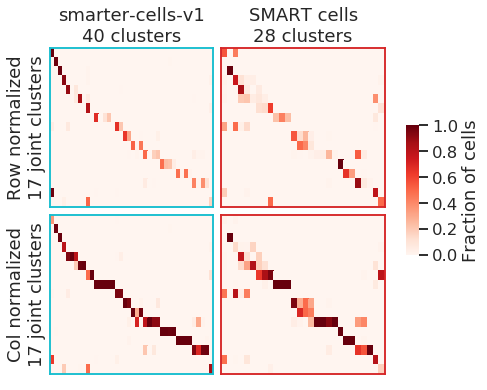

In [25]:
# confusion matrix

nx = len(mods_ordered)
ny = 2
heatmap_kws = {
    'xticklabels': False, 
    'yticklabels': False,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'Reds',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info['cluster_joint_r1'].unique())
    for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
        conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, 'cluster'], 
                               df_info.loc[df_info['modality']==mod, 'cluster_joint_r1'],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint
            _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.3)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

            order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel('')

            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
            
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format(5, 'pdf'), bbox_inches='tight')
    plt.show()

In [26]:
ftrs_f = os.path.join(DATA_DIR, '{0}_raw.{1}')
ftrs_gene = os.path.join(DATA_DIR, '{0}_raw.gene')
ftrs_cell = os.path.join(DATA_DIR, '{0}_raw.cell')

raw_f = os.path.join(DATA_DIR, '{0}_{1}raw.npz')
raw_gene = os.path.join(DATA_DIR, '{0}_raw.gene')
raw_cell = os.path.join(DATA_DIR, '{0}_raw.cell')

gxc_ftrs = collections.OrderedDict()
for mod in mods_selected:
    print(mod)
    ti = time.time()
    
    if settings[mod].mod_category == 'mc':
        _mat_c = sparse.load_npz(raw_f.format(mod, 'CH_')) 
        _mat_mc = sparse.load_npz(raw_f.format(mod, 'mCH_')) 
        _gene = pd.read_csv(raw_gene.format(mod), sep='\t', header=None).iloc[:, 0].values #gene_name
        _gene = SCF_utils.standardize_gene_name(_gene)
        _cell = pd.read_csv(raw_cell.format(mod), sep='\t', header=None).iloc[:, 0].values 
        gxc_raw = GC_matrix(_gene, _cell, 
                                  {'c': _mat_c, 'mc': _mat_mc})
        
        base_call_cutoff = 20
        sufficient_coverage_fraction = 0.95
        # select genes covered (20 counts) in > 95% of cells
        n_gene, n_cell = gxc_raw.data['c'].shape
        gene_cov = (gxc_raw.data['c'] > base_call_cutoff).sum(axis=1)
        gene_cov = np.array(gene_cov).squeeze()/n_cell # fraction of cells covered
        cond = gene_cov>sufficient_coverage_fraction
        
        # to full matrix
        df_c = pd.DataFrame(
            gxc_raw.data['c'].tocsr()[cond, :].todense(),
            index=np.array(gxc_raw.gene)[cond],
            columns=gxc_raw.cell,
        )
        df_mc = pd.DataFrame(
            gxc_raw.data['mc'].tocsr()[cond, :].todense(),
            index=np.array(gxc_raw.gene)[cond],
            columns=gxc_raw.cell,
        )

        # compute normalized methylation matrix 
        df_mcc = snmcseq_utils.get_mcc_lite_v2(df_c, df_mc, base_call_cutoff=base_call_cutoff)
        gxc_ftrs[mod] = df_mcc.divide(metas[mod].loc[df_mcc.columns.values, 'mCH'], axis=1)
        del df_c, df_mc, df_mcc
        
        print(gxc_ftrs[mod].shape, time.time()-ti)
        continue
        
    f_mat = raw_f.format(mod, '')
    f_gene = raw_gene.format(mod)
    f_cell = raw_cell.format(mod)
    
    _mat = sparse.load_npz(f_mat) 
    _gene = pd.read_csv(f_gene, sep='\t', header=None).iloc[:, 0].values
    _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
    _cell = pd.read_csv(f_cell, sep='\t', header=None).iloc[:, 0].values 
    
    gxc_raw = GC_matrix(_gene, _cell, _mat)
    gxc_ftrs[mod] = snmcseq_utils.sparse_logcpm(gxc_raw, mode='logcpm')
    
    del gxc_raw, _mat
    print(gxc_ftrs[mod].data.shape, time.time()-ti)
    

smarter_cells
(23017, 4152) 4.744204759597778
smarter-cells-v1
(45768, 7366) 12.532357215881348


In [27]:
sample_n = 5000

In [152]:
def plot_gene_tsne(genes_inq, nx=len(mods_selected)):    
    with sns.plotting_context('talk'), sns.axes_style('white'):
        n = len(mods_ordered)
        nx = nx
        ny = int((n+nx-1)/nx)
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
        axs = axs.flatten()
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]

        cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6])

        for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
            if settings[mod].mod_category == 'mc':
                genes = gxc_ftrs[mod].index.values
                uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
                gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
    #             gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
                gene_data = gxc_ftrs[mod].iloc[gene_idx].T
                # normalize gene_data
            else:
                genes = gxc_ftrs[mod].gene
                cells = gxc_ftrs[mod].cell
                uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
                gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
    #             gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
                gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
                gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
#                 # normalize gene_data
#                 gene_data = gene_data.applymap(lambda x: np.log10(x+1))

#             # normalize gene_data
#             gene_data = settings[mod].mod_direction*(gene_data - gene_data.mean())/gene_data.std()

            df_mod = df_info[df_info['modality']==mod]
            if sample_n > len(df_mod):
                df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
            else:
                df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                             .sample(sample_n, replace=False)
                          )

            if i == 0: 
                cbar = True
            else:
                cbar = False
            snmcseq_utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
                                              s=2,
                                              cbar=cbar,
                                              cbar_ax=cbar_ax,
                                              cmap='rocket_r',
                                              rasterized=True,
                                             )
    #         ax.set_title('{} '.format(settings[mod].name, ))
            ax.set_title(genes_inq[0])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('auto')

            for _, spine in ax.spines.items():
                spine.set_color(settings[mod].color)
                spine.set_linewidth(3)

        for ax in axs[n:]:
            ax.axis('off')
#         cbar_ax.axis('off')


        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight')
        plt.show()


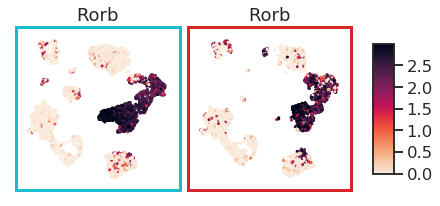

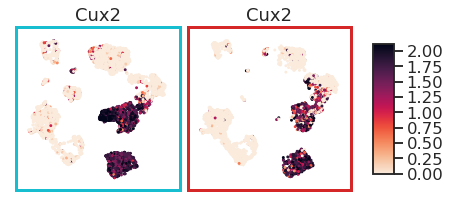

In [153]:
# genes_inq = ['Thsd7a']
# plot_gene_tsne(genes_inq)

genes_inq = ['Rorb']
plot_gene_tsne(genes_inq)

genes_inq = ['Cux2']
plot_gene_tsne(genes_inq)

In [144]:
genes_inq = [
#     'Snap25',
    
#     'Satb2',
#     'Camk2a',
#     'Tbr1',
    
#     'Gad1',
#     'Gad2',
#     'Slc6a1',
    
    'Cux1',
    'Cux2',
    'Rorb',
    'Deptor',
    'Vat1l',
    'Sulf1',
    'Tle4',
    'Foxp2',
    'Grik3',
    'Bcl6',
    'Tshz2', 
    
#     'Lhx6',
#     'Adarb2',
    
#     'Pvalb',
#     'Sox6',
#     'Gria1',
    
#     'Prox1',
#     'Sv2c',
    
    ]
clsts_uniq = np.sort(np.unique(df_info['cluster_joint_r1']))

df_plots = {} 
for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
#         gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
        uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
        gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        gene_data = gxc_ftrs[mod].iloc[gene_idx].T
        # normalize gene_data
    else:
        genes = gxc_ftrs[mod].gene
        cells = gxc_ftrs[mod].cell
#         gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
        uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
        gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        gene_data = gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense().T
        gene_data = pd.DataFrame(gene_data, index=cells, columns=genes_inq)
#         # normalize gene_data
#         gene_data = gene_data.applymap(lambda x: np.log10(x+1))
    
    
    df_mod = df_info.loc[df_info['modality']==mod, ['cluster_joint_r1']]
    if sample_n > len(df_mod):
        df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
    else:
        df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                     .sample(sample_n, replace=False)
                  )
    df_plot = df_plot.groupby('cluster_joint_r1').mean()
    
    # normalize gene_data
#     df_plot = settings[mod].mod_direction*(df_plot - df_plot.mean(axis=0))/df_plot.std(axis=0)
    df_plot = settings[mod].mod_direction*df_plot
    df_plots[mod] = df_plot.T.reindex(
                                    index=genes_inq, 
                                    columns=clsts_uniq,
                                    )

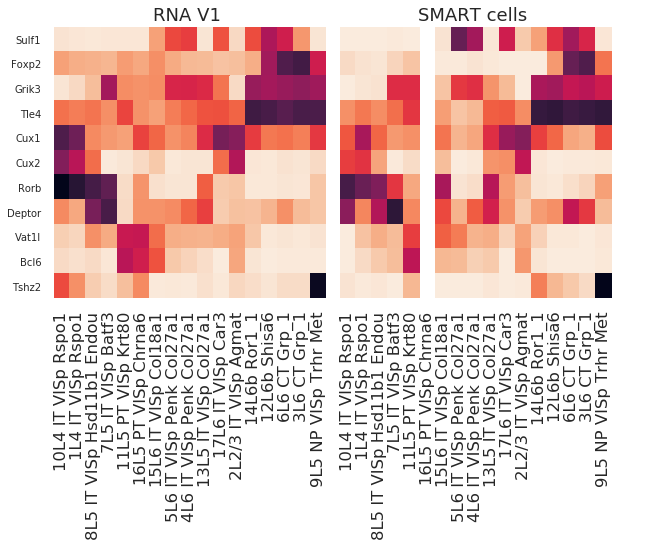

In [145]:
import scipy.cluster.hierarchy as sch
with sns.plotting_context('talk'), sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 2
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(5*nx,5*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if i == 0: 
            cbar = False
            # row gene
            Z = sch.linkage(df_plots[mod], method='average', metric='euclidean', optimal_ordering=True)
            dn = sch.dendrogram(Z, no_plot=True)['leaves']
            # col clst
            Z = sch.linkage(df_plots[mod].T, method='average', metric='euclidean', optimal_ordering=True)
            dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
        else:
            cbar = False
            
        sns.heatmap(df_plots[mod].iloc[dn, dn_clst], ax=ax, 
                                     cbar=cbar,
                                    yticklabels=True,
                                     cbar_ax=cbar_ax,
                                     cmap='rocket_r',
                                    xticklabels=True,
                                     )
        ax.set_title('{} '.format(settings[mod].name, ))
#         ax.set_xticks([])
        
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
        else:
            ax.set_yticks([])
        ax.set_xlabel('')
            
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
            
        clsts = df_plots[mod].iloc[:, dn_clst].columns.values
        ax.set_xticklabels(clsts.astype(str)+np.ravel(joint_annot.loc[clsts].values))
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('7_gene_heatmap', 'pdf'), bbox_inches='tight')
    plt.show()
    

### L4 - differences (integrated cluster 10 and cluster 1)

In [108]:
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests # (pvals, alpha=0.05, method='hs', is_sorted=False, returnsorted=False)

In [89]:

cond = ((df_info['modality']=='smarter-cells-v1') 
        & (df_info['cluster_joint_r1']==1)
       )
cells_x = df_info[cond].index.values

cond = ((df_info['modality']=='smarter-cells-v1') 
        & (df_info['cluster_joint_r1']==10)
       )
cells_y = df_info[cond].index.values 

features = pd.DataFrame(gxc_ftrs['smarter-cells-v1'].data.todense(),
                        index=gxc_ftrs['smarter-cells-v1'].gene,
                        columns=gxc_ftrs['smarter-cells-v1'].cell,
                       )
features_x = features[cells_x]
features_y = features[cells_y]
print(features.shape)
features.head()

(45768, 7366)


,F1S4_161209_001_A01,F1S4_161209_001_B01,F1S4_161209_001_C01,F1S4_161209_001_D01,F1S4_161209_001_E01,F1S4_161209_001_F01,F1S4_161209_001_G01,F1S4_161209_001_H01,F1S4_161209_002_A01,F1S4_161209_002_B01,...,FYS4_171003_509_F01,FYS4_171003_509_G01,FYS4_171004_102_A01,FYS4_171004_102_D01,FYS4_171004_102_E01,FYS4_171004_103_E01,FYS4_171004_103_F01,FYS4_171004_103_H01,FYS4_171004_104_C01,FYS4_171004_104_F01
0610005c13rik,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610006l08rik,0.000000,0.000000,0.000000,0.163287,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0610007p14rik,1.819267,2.049879,2.257042,1.969404,1.791502,2.421478,2.016243,2.013851,1.975635,1.979649,...,2.104047,1.850025,2.205183,2.060203,2.174824,1.929834,1.915331,1.656925,2.282092,2.071017
0610009b22rik,2.199325,2.023363,1.754443,1.359993,1.591573,2.184902,1.896225,2.026915,1.606761,1.386969,...,0.991034,1.702781,1.640425,1.785220,1.977848,1.676621,1.800077,1.913187,1.732103,2.371809
0610009e02rik,0.661234,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.688215,0.000000,0.000000,0.000000,0.000000,0.868841,0.000000,0.000000,0.000000


In [127]:
ps = []
fcs = []
for i in range(len(features_x)):
    _x = features_x.iloc[i].values
    _y = features_y.iloc[i].values
    fc = _y.mean() - _x.mean()
#     fc = np.median(_y) - np.median(_x)
    try:
        s, p = mannwhitneyu(_x, _y, alternative='two-sided')
    except:
        p = 1
    ps.append(p)
    fcs.append(fc)
    
de_test = pd.DataFrame(index=features_x.index)
de_test['p'] = ps
de_test['fc'] = fcs
de_test['q'] = multipletests(ps, alpha=0.05, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
de_test['fc_abs'] = de_test['fc'].abs() 

print(de_test.shape)
de_test.head()

(45768, 3)


,p,fc,q
0610005c13rik,9.861185e-01,-0.007928,1.000000e+00
0610006l08rik,9.055431e-02,0.002238,2.218915e-01
0610007p14rik,3.182712e-19,-0.250608,3.889623e-18
0610009b22rik,4.557558e-38,-0.531966,1.077986e-36
0610009e02rik,4.410174e-01,0.022365,7.135582e-01


In [139]:
res_test = de_test[de_test['q']<0.01].sort_values('fc_abs', ascending=False)
res_test.head()

,p,fc,q,fc_abs
9530091c08rik,1.457120e-89,0.962940,1.383599e-87,0.962940
Thsd7a,2.210033e-91,0.936860,2.278126e-89,0.936860
Loc105246694,1.678374e-74,0.923733,1.062459e-72,0.923733
Galntl6,2.267622e-79,0.899012,1.624171e-77,0.899012
Wbscr17,6.753045e-110,0.891432,1.148972e-107,0.891432


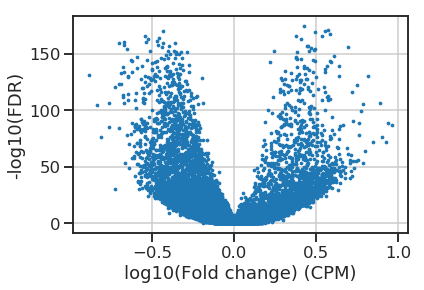

In [142]:
fig, ax = plt.subplots()
ax.scatter(de_test['fc'].values, -np.log10(de_test['q'].values), s=5, rasterized=True)
ax.set_ylabel('-log10(FDR)')
ax.set_xlabel('log10(Fold change) (CPM)')
fig.savefig(output_figures.format('DE_genes', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [32]:
gxc_ftrs['smarter-cells-v1']
gxc_ftrs_clst = collections.OrderedDict()
for mod in mods_selected:
    gxc_ftrs_clst[mod] = pd.DataFrame(index=gxc_ftrs[mod].gene)
    
for (clst, modality), df_sub in df_info.groupby(['cluster_joint_r1', 'modality']):
    if clst in [1, 10]:
        cells = df_sub.index.values
        cells_idx = snmcseq_utils.get_index_from_array(gxc_ftrs[modality].cell, cells)
        x = np.ravel(gxc_ftrs[modality].data.tocsc()[:, cells_idx].mean(axis=1))
        gxc_ftrs_clst[modality][clst] = np.ravel(gxc_ftrs[modality].data.tocsc()[:, cells_idx].mean(axis=1))
        print(clst, modality)

1 smarter-cells-v1
1 smarter_cells
10 smarter-cells-v1
10 smarter_cells


In [33]:
gxc_ftrs_clst['smarter_cells'].head()

,1,10
0610007p14rik,1.943709,1.276130
0610009b22rik,1.904517,0.471750
0610009l18rik,0.266495,0.000000
0610009o20rik,0.509178,0.942209
0610010f05rik,1.756240,1.644562


In [34]:
_x = gxc_ftrs_clst['smarter-cells-v1'][1]
_y = gxc_ftrs_clst['smarter-cells-v1'][10] #.head()

In [71]:
res = (_y - _x).sort_values(ascending=False)
res.head()

9530091c08rik    0.962940
Thsd7a           0.936860
Loc105246694     0.923733
Galntl6          0.899012
Wbscr17          0.891432
dtype: float64

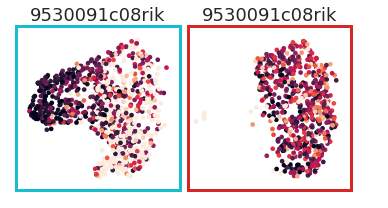

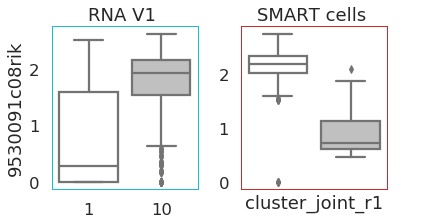

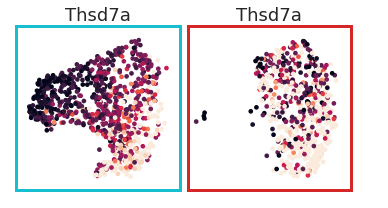

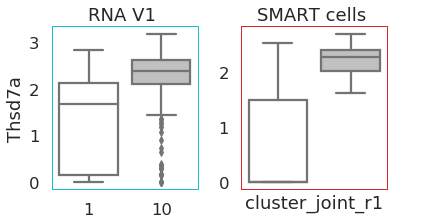

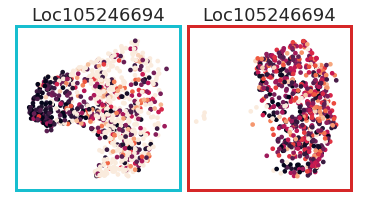

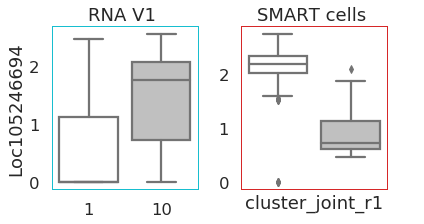

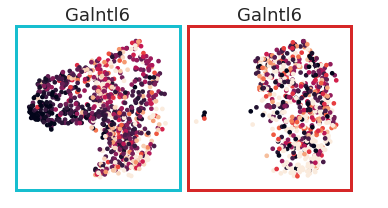

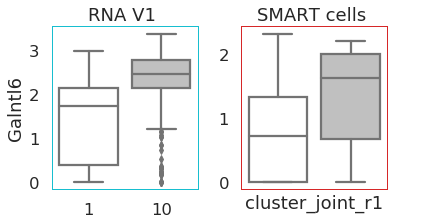

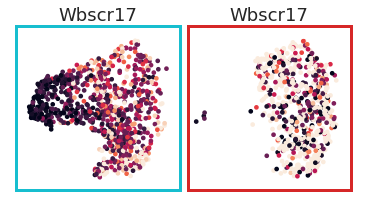

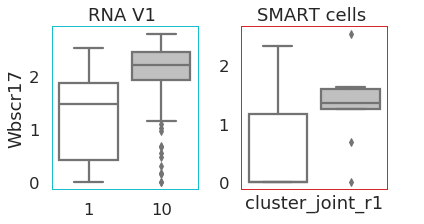

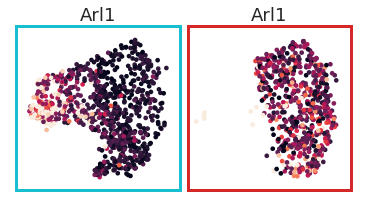

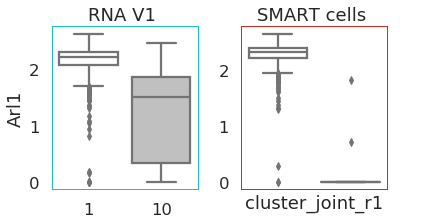

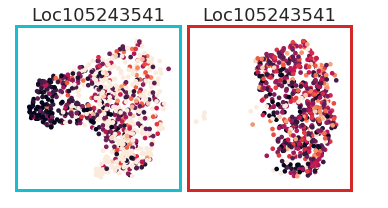

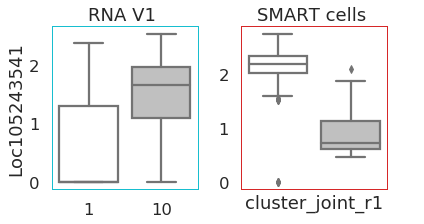

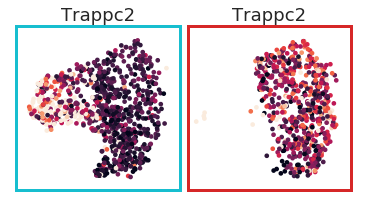

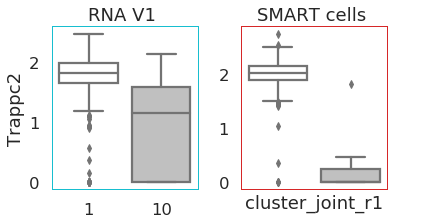

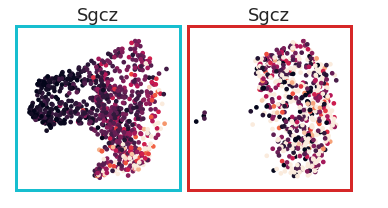

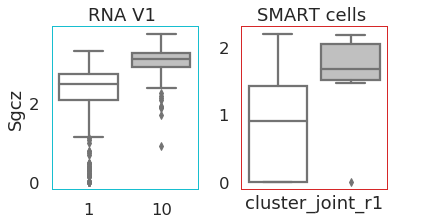

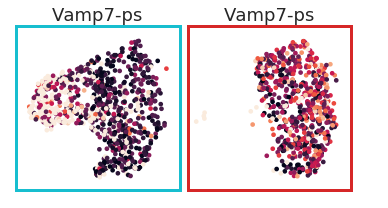

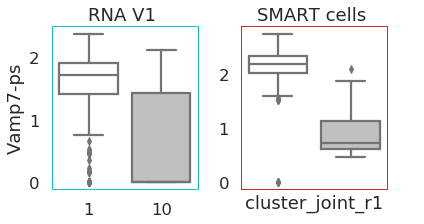

In [140]:
# gene_list = res.head(10).index.values 
gene_list = [
#     'Galntl6', 
#     'Wbscr17', 
#     'Grip1', 
#     'Ppargc1a', 
#     'Slit3',
#     'Vamp7-ps', 
#     'Trappc2',
#     'Arl1',
#     'Clu',
]

gene_list = res_test.head(10).index.values


for gene in gene_list:
    genes_inq = [gene]
    clsts = [1, 10]
#     plot_gene_tsne(genes_inq)
    plot_gene_tsne_subtypes(genes_inq, clsts)
    plot_gene_box_subtypes(genes_inq, clsts)
#     break
    

In [271]:
[
    'Grip1', 
    'Ppargca1', 
    'Slit3',
    
    'Vamp7-ps', 
    'Trappc2',
    'Arl1',
    'Clu',
]

['Vamp7-ps', 'Trappc2', 'Arl1', 'Clu']

In [133]:
def plot_gene_tsne_subtypes(genes_inq, clsts, nx=len(mods_selected)):    
    """
    """
    with sns.plotting_context('talk'), sns.axes_style('white'):
        n = len(mods_ordered)
        nx = nx
        ny = int((n+nx-1)/nx)
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
        axs = axs.flatten()
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]

        cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])

        for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
            if settings[mod].mod_category == 'mc':
                genes = gxc_ftrs[mod].index.values
                uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
                gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
    #             gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
                gene_data = gxc_ftrs[mod].iloc[gene_idx].T
                # normalize gene_data
            else:
                genes = gxc_ftrs[mod].gene
                cells = gxc_ftrs[mod].cell
                uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
                gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
    #             gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
                gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
                gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
#                 # normalize gene_data
#                 gene_data = gene_data.applymap(lambda x: np.log10(x+1))

#             # normalize gene_data
#             gene_data = settings[mod].mod_direction*(gene_data - gene_data.mean())/gene_data.std()

            df_mod = df_info[df_info['modality']==mod]
            if sample_n > len(df_mod):
                df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
            else:
                df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                             .sample(sample_n, replace=False)
                          )

            if i == 0: 
                cbar = False
            else:
                cbar = False
            df_plot = df_plot[df_plot['cluster_joint_r1'].isin(clsts)]
            snmcseq_utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
                                              s=10,
                                              cbar=cbar,
                                              cbar_ax=cbar_ax,
                                              cmap='rocket_r',
                                              rasterized=True,
                                             )
    #         ax.set_title('{} '.format(settings[mod].name, ))
            ax.set_title(genes_inq[0])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect('auto')

            for _, spine in ax.spines.items():
                spine.set_color(settings[mod].color)
                spine.set_linewidth(3)

        for ax in axs[n:]:
            ax.axis('off')
        cbar_ax.axis('off')


        fig.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight', dpi=300)
        plt.show()


In [96]:
def plot_gene_box_subtypes(genes_inq, clsts):
    with sns.plotting_context('talk'), sns.axes_style('white'):
        n = len(mods_ordered)
        nx = 2
        ny = int((n+nx-1)/nx)
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
        axs = axs.flatten()
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]

        cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])

        for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
            if settings[mod].mod_category == 'mc':
                genes = gxc_ftrs[mod].index.values
                uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
                gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
    #             gene_idx = snmcseq_utils.get_index_from_array(genes, genes_inq)
                gene_data = gxc_ftrs[mod].iloc[gene_idx].T
                # normalize gene_data
            else:
                genes = gxc_ftrs[mod].gene
                cells = gxc_ftrs[mod].cell
                uniq_gene_idx = pd.Series(genes).reset_index().groupby(0).first().sort_values('index')['index'].values
                gene_idx = uniq_gene_idx[snmcseq_utils.get_index_from_array(genes[uniq_gene_idx], genes_inq)]
                gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
                gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
#                 normalize gene_data
#                 gene_data = gene_data.applymap(lambda x: np.log10(x+1))

            df_mod = df_info[df_info['modality']==mod]
            if sample_n > len(df_mod):
                df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
            else:
                df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                             .sample(sample_n, replace=False)
                          )

            df_plot = df_plot[df_plot['cluster_joint_r1'].isin(clsts)]
#             sns.stripplot(data=df_plot, y=tc, x='cluster_joint_r1', color='grey', ax=ax)
            sns.boxplot(data=df_plot, y=tc, x='cluster_joint_r1', palette=['white', 'silver'], ax=ax)
            if i == 0: 
                cbar = False
                ax.set_xlabel('')
            else:
                cbar = False
                ax.set_xticks([])
                ax.set_ylabel('')
#                 ax.set_yticks([])
#                 ax.set_xlabel('')
                
            ax.set_title('{} '.format(settings[mod].name, ))
#             ax.set_title('')

            for _, spine in ax.spines.items():
                spine.set_color(settings[mod].color)
                spine.set_linewidth(1)

        for ax in axs[n:]:
            ax.axis('off')
        cbar_ax.axis('off')


        fig.subplots_adjust(hspace=0.05, wspace=0.30)
#         fig.tight_layout()
        fig.savefig(output_figures.format('6-2_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight')
        plt.show()
